(learning)=
# Learning

**THIS CHAPTER IS CURRENTLY UNDER CONSTRUCTION!!!**

## Maximum likelihood estimation

Let's begin with a simple example. Suppose that we flip a coin $m\geq 1$ times and let $x_i$ be the number of heads obtained on the $i$-th toss; thus, $x_i$ is an observed value of a random variable

$$
X \sim \Ber(\theta).
$$

This is a very simple example of a probabilistic graphical model whose underlying graph is of the form

```{image} ../img/bern-pgm.svg
:width: 30%
:align: center
```
&nbsp;

Our observations together form a dataset of size $m$:

$$
x_1,x_2,\ldots,x_m \in \bbr.
$$ (bern-dataset-eqn)

The dataset suggests certain values of the unknown parameter $\theta$ that are "better" than others. For example, if $m=10$ and the total number of heads

$$
x = x_1 + \cdots + x_{m}
$$ (sum-dep-eqn)

is $x=7$, then a value of $\theta=0.7$ seems like a "better" choice compared to, say, $\theta=0.1$. Indeed, if $\theta=0.1$, then we would expect it highly unlikely to observe a dataset {eq}`bern-dataset-eqn` of size $m=10$ containing $x=7$ heads.

We may confirm our hunch by actually computing probabilities. Assuming, as always, that the observations in the dataset are independent, we have

$$
p(x_1,\ldots,x_m;\theta) = \prod_{i=1}^m \theta^{x_i}(1-\theta)^{1-x_i} = \theta^x (1-\theta)^{m-x}.
$$ (likelihood-bern-eqn)

Notice that the value of the joint mass function depends only on the sum {eq}`sum-dep-eqn`. If this sum is $x=7$, and we have $m=10$ and $\theta=0.1$, then

$$
p(x_1,\ldots,x_m;\theta=0.1) = 0.1^{7} (1-0.1)^{10-7} = 7.29 \times 10^{-8}.
$$

On the other hand, when $\theta=0.7$, we have

$$
p(x_1,\ldots,x_m;\theta=0.7) = 0.7^{7} (1-0.7)^{10-7} \approx 2.22 \times 10^{-3}.
$$

Thus, it is five orders of magnitude more likely to observe a dataset with $x=7$ for $\theta=0.7$ compared to $\theta=0.1$. In fact, when $x=7$ and $m=10$, the value $\theta = 0.7$ is a maximizer of the function {eq}`likelihood-bern-eqn`, which may be verified by inspecting the graph:

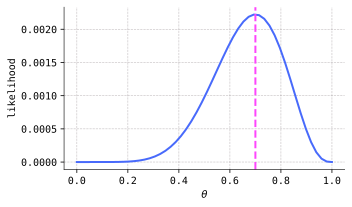

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from itertools import product
import warnings
plt.style.use('../aux-files/custom_style_light.mplstyle')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
warnings.filterwarnings("ignore")
blue = '#486AFB'
magenta = '#FD46FC'

def likelihood(theta, x, m):
    return (theta ** x) * ((1 - theta) ** (m - x))

m = 10
x = 7
grid = np.linspace(0, 1)
plt.plot(grid, likelihood(grid, x, m))
plt.axvline(x=0.7, color=magenta, linestyle='--')
plt.xlabel('$\\theta$')
plt.ylabel('likelihood')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

Note the label along the vertical axis; when the dataset is held fixed, the values of the joint mass function {eq}`likelihood-bern-eqn` as a function of the parameter $\theta$ are refered to as _likelihoods_. Hence, this function is called the _(data) likelihood function_ and is denoted

$$
\mathcal{L}(\theta;x_1,\ldots,x_m) = p(x_1,\ldots,x_m;\theta).
$$

When the dependence of the likelihood function on the dataset does not need to be explicitly indicated, we shall often simply write $\mathcal{L}(\theta)$.

```{warning}
Note that the likelihood function $\mathcal{L}(\theta)$ is **not** a probability density function over $\theta$!
```